In [1]:
# coding: utf-8
from __future__ import print_function
import os
import numpy as np
import time
np.random.seed(1337)

import theano
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Activation
from keras.layers import Convolution1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model
from keras.layers import Input, Dropout
from keras.optimizers import SGD, Adadelta
from keras.models import Sequential
import sys

BASE_DIR = '.'
GLOVE_DIR = BASE_DIR + '/glove.twitter.27B/'

TEXT_DATA_DIR = BASE_DIR + '/20_newsgroups/'

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
CONVOLUTION_FEATURE = 256
DENSE_FEATURE = 1024
DROP_OUT = 0.3

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')
print('Embedding Dimesions: %s' % (str(EMBEDDING_DIM)))

embeddings_index = {}
fname = os.path.join(GLOVE_DIR, 'glove.twitter.27B.' + str(EMBEDDING_DIM) + 'd.txt')
f = open(fname)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                texts.append(f.read())
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Preparing embedding matrix.')

# prepare embedding matrix
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
# embedding_layer = Embedding(nb_words + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=False)

print('Training model.')
model = Sequential()

model.add(Embedding(                          # Layer 0, Start
    input_dim=nb_words + 1,                   # Size to dictionary, has to be input + 1
    output_dim=EMBEDDING_DIM,                 # Dimensions to generate
    weights=[embedding_matrix],               # Initialize word weights
    input_length=MAX_SEQUENCE_LENGTH))        # Define length to input sequences in the first layer

model.add(LSTM(128, dropout_W=0.2, dropout_U=0.2))  # try using a GRU instead, for fun
model.add(Dense(20))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Done compiling.")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
Using Theano backend.


Indexing word vectors.
Embedding Dimesions: 100
Found 1193514 word vectors.
Processing text dataset
Found 19997 texts.
Found 214909 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)
Preparing embedding matrix.
Training model.
Done compiling.


In [2]:
start = time.time()

history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    nb_epoch=25, batch_size=100)

print ("Training Time : ", time.time() - start)

Train on 15998 samples, validate on 3999 samples
Epoch 1/25
15998/15998 [==============================] - 87s - loss: 2.8192 - acc: 0.1154 - val_loss: 2.6118 - val_acc: 0.1573

['acc', 'loss', 'val_acc', 'val_loss']


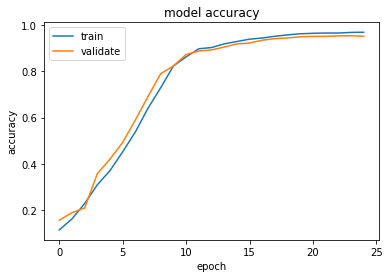

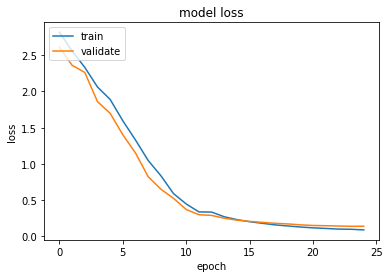

In [3]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [4]:
print(history.history)

{'acc': [0.11538942395319997, 0.16283285475877066, 0.2292786595828534, 0.31016377168590537, 0.37148393676241931, 0.45249406064744441, 0.53831728706808146, 0.64089261210550441, 0.72927866069685443, 0.82291536287808953, 0.8619202379510319, 0.89711214103673698, 0.90230028951059271, 0.91811476548562454, 0.92836605018191765, 0.93842980454513203, 0.94361795553759886, 0.95093136793345956, 0.9569321186605998, 0.96174522144583741, 0.96380797692098708, 0.96499562865570943, 0.96493312236234119, 0.96762095993646224, 0.96837105152234093], 'loss': [2.819175980928347, 2.5598204193718508, 2.3334764255733993, 2.0627177628089015, 1.8906571016801657, 1.5950464738996524, 1.3289610556266147, 1.0461506961449816, 0.83580404640749284, 0.58725854317416759, 0.4450712121044163, 0.33515431927075789, 0.33299333816886706, 0.26803092054574695, 0.2286820684277068, 0.19960933556920635, 0.17775949678364092, 0.15605600946399475, 0.14091289642341795, 0.12672655076600714, 0.11489580547154613, 0.10658825347033542, 0.097515